C:\Users\KIIT\AppData\Local\Temp\ipykernel_15836\3288096175.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


           STORE_NBR  LYLTY_CARD_NBR        TXN_ID       PROD_NBR  \
count  246742.000000    2.467420e+05  2.467420e+05  246742.000000   
mean      135.051098    1.355310e+05  1.351311e+05      56.351789   
std        76.787096    8.071528e+04  7.814772e+04      33.695428   
min         1.000000    1.000000e+03  1.000000e+00       1.000000   
25%        70.000000    7.001500e+04  6.756925e+04      26.000000   
50%       130.000000    1.303670e+05  1.351830e+05      53.000000   
75%       203.000000    2.030840e+05  2.026538e+05      87.000000   
max       272.000000    2.373711e+06  2.415841e+06     114.000000   

            PROD_QTY      TOT_SALES  
count  246742.000000  246742.000000  
mean        1.908062       7.321322  
std         0.659831       3.077828  
min         1.000000       1.700000  
25%         2.000000       5.800000  
50%         2.000000       7.400000  
75%         2.000000       8.800000  
max       200.000000     650.000000  
<class 'pandas.core.frame.DataFrame'

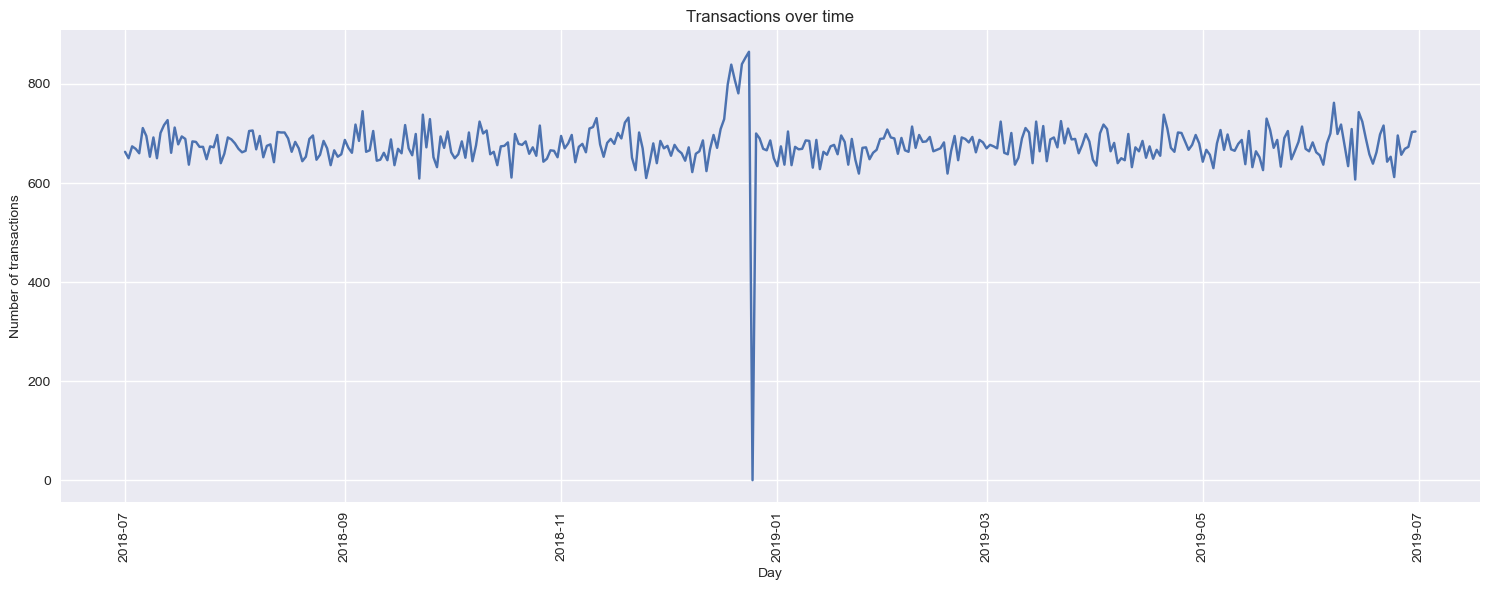

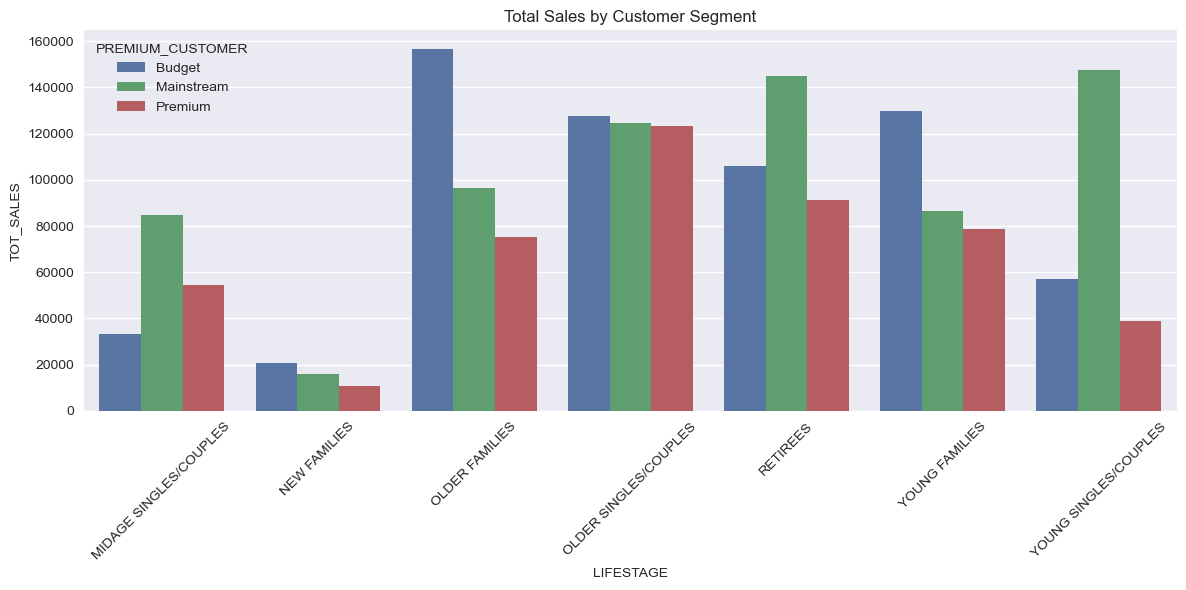


t-statistic: 37.83196107667815
p-value: 2.235645611549355e-309


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set plotting style
plt.style.use('seaborn')

# Read the data
# Note: Replace with your actual file path
file_path = "C:/Users/KIIT/Desktop/QVI_transaction_data.xlsx"
transaction_data = pd.read_excel("QVI_transaction_data.xlsx")
customer_data = pd.read_csv("QVI_purchase_behaviour.csv")

# Convert DATE to datetime format
# Note: In Python, we need to handle dates differently than R
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')

# Remove salsa products
transaction_data['SALSA'] = transaction_data['PROD_NAME'].str.lower().str.contains('salsa')
transaction_data = transaction_data[~transaction_data['SALSA']].drop('SALSA', axis=1)

# Basic data examination
print(transaction_data.describe())
print(transaction_data.info())

# Investigate outliers (200 quantity purchases)
outliers = transaction_data[transaction_data['PROD_QTY'] >= 200]
print("\nOutlier transactions:")
print(outliers)

# Remove outlier customer
transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != outliers['LYLTY_CARD_NBR'].iloc[0]]

# Transaction count by date
daily_transactions = transaction_data.groupby('DATE').size().reset_index(name='N')

# Create complete date range
date_range = pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')
transactions_by_day = pd.DataFrame({'DATE': date_range})
transactions_by_day = transactions_by_day.merge(daily_transactions, how='left', on='DATE').fillna(0)

# Plot transactions over time
plt.figure(figsize=(15, 6))
plt.plot(transactions_by_day['DATE'], transactions_by_day['N'])
plt.title('Transactions over time')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Extract pack size from product name
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract('(\d+)').astype(float)

# Create brand names
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0]

# Clean brand names
brand_mapping = {
    'RED': 'RRD',
    # Add more brand mappings as needed
}
transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_mapping)

# Merge transaction and customer data
data = transaction_data.merge(customer_data, how='left')

# Analysis by customer segments
# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
segment_sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Plot segment sales
plt.figure(figsize=(12, 6))
segment_plot = sns.barplot(data=segment_sales, 
                          x='LIFESTAGE', 
                          y='TOT_SALES', 
                          hue='PREMIUM_CUSTOMER')
plt.title('Total Sales by Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Customer count by segment
customer_counts = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()

# Units per customer
units_per_customer = (data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
                     .agg({'PROD_QTY': 'sum', 'LYLTY_CARD_NBR': 'nunique'})
                     .reset_index())
units_per_customer['UNITS_PER_CUSTOMER'] = units_per_customer['PROD_QTY'] / units_per_customer['LYLTY_CARD_NBR']

# Average price per unit
data['PRICE_PER_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().reset_index()

# Statistical test (t-test example)
from scipy import stats

mainstream_price = data[
    (data['PREMIUM_CUSTOMER'] == 'Mainstream') & 
    (data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))
]['PRICE_PER_UNIT']

other_price = data[
    (data['PREMIUM_CUSTOMER'] != 'Mainstream') & 
    (data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))
]['PRICE_PER_UNIT']

t_stat, p_value = stats.ttest_ind(mainstream_price, other_price)
print(f"\nt-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Save the final dataset
data.to_csv(f"{file_path}QVI_data.csv", index=False)